# Pion Stop Regression Validation

Validate regression predictions from existing parquet prediction files. This notebook does not run inference; it reads `ml_output_*.parquet` truth and `pion_stop_regression` prediction parquet files, aligns by `(event_id, time_group_id)`, and computes metrics/plots.

In [1]:
from pathlib import Path
import numpy as np
import polars as pl
import matplotlib.pyplot as plt

from pioneerml.common.zenml import utils as zenml_utils


In [2]:
PROJECT_ROOT = zenml_utils.find_project_root()
zenml_utils.setup_zenml_for_notebook(root_path=PROJECT_ROOT, use_in_memory=True)
print(f"Project root: {PROJECT_ROOT}")

data_dir = PROJECT_ROOT / 'data'
pred_dirs = [data_dir / 'pion_stop_regression', data_dir / 'pion_stop']
pred_dir = next((d for d in pred_dirs if d.exists()), pred_dirs[0])
if not pred_dir.exists():
    raise RuntimeError(
        f"Prediction directory not found: {pred_dirs[0]} (fallback {pred_dirs[1]})"
    )

main_paths = sorted(data_dir.glob('ml_output_*.parquet'))
# Example: uncomment to validate a smaller subset
main_paths = main_paths[:1]
if not main_paths:
    raise RuntimeError(f'No main parquet files found in {data_dir}')

aligned = []
missing = []
for main_path in main_paths:
    p1 = pred_dir / f'{main_path.stem}_preds.parquet'
    p2 = pred_dir / f'{main_path.stem}_preds_latest.parquet'
    pred_path = p1 if p1.exists() else (p2 if p2.exists() else None)
    if pred_path is None:
        missing.append(main_path.name)
        continue
    aligned.append((main_path, pred_path))

if missing:
    raise RuntimeError('Missing predictions for: ' + ', '.join(missing))

print(f'Aligned files: {len(aligned)}')
for m, p in aligned:
    print(f' - {m.name} -> {p.name}')


Using ZenML repository root: /workspace
Ensure this is the top-level of your repo (.zen must live here).
Project root: /workspace
Aligned files: 1
 - ml_output_000.parquet -> ml_output_000_preds.parquet


In [3]:
TARGET_COLS = ['pion_stop_x', 'pion_stop_y', 'pion_stop_z']
PRED_BASE_COLS = ['pred_pion_stop_x', 'pred_pion_stop_y', 'pred_pion_stop_z']

def flatten_truth(main_path: Path) -> pl.DataFrame:
    cols = ['event_id', 'hits_time_group', *TARGET_COLS]
    df = pl.read_parquet(main_path, columns=cols)
    df = df.with_columns(pl.col('hits_time_group').list.unique().list.sort().alias('time_group_ids'))
    out = df.select(['event_id', 'time_group_ids', *TARGET_COLS]).explode(['time_group_ids', *TARGET_COLS])
    out = out.rename({'time_group_ids': 'time_group_id'})
    out = out.with_columns(
        pl.col('event_id').cast(pl.Int64),
        pl.col('time_group_id').cast(pl.Int64).fill_null(-1),
    )
    return out

def flatten_preds(pred_path: Path) -> pl.DataFrame:
    q16_cols = [f'{c}_q16' for c in PRED_BASE_COLS]
    q50_cols = [f'{c}_q50' for c in PRED_BASE_COLS]
    q84_cols = [f'{c}_q84' for c in PRED_BASE_COLS]
    cols = ['event_id', 'time_group_ids', *PRED_BASE_COLS, *q16_cols, *q50_cols, *q84_cols]
    df = pl.read_parquet(pred_path, columns=cols)
    out = df.explode(['time_group_ids', *PRED_BASE_COLS, *q16_cols, *q50_cols, *q84_cols])
    out = out.rename({'time_group_ids': 'time_group_id'})
    out = out.with_columns(
        pl.col('event_id').cast(pl.Int64),
        pl.col('time_group_id').cast(pl.Int64).fill_null(-1),
    )
    out = out.filter(pl.all_horizontal(*[pl.col(c).is_not_null() for c in q50_cols]))
    return out

joined_frames = []
for main_path, pred_path in aligned:
    truth = flatten_truth(main_path)
    pred = flatten_preds(pred_path)
    joined = truth.join(pred, on=['event_id', 'time_group_id'], how='inner')
    if joined.height != pred.height:
        raise RuntimeError(
            f'Alignment mismatch for {main_path.name} / {pred_path.name}: '
            f'truth={truth.height}, pred_non_null={pred.height}, matched={joined.height}'
        )
    coverage = (pred.height / truth.height) if truth.height > 0 else 0.0
    print(f'{main_path.name}: predicted groups={pred.height}/{truth.height} ({coverage:.1%})')
    joined_frames.append(joined)

df = pl.concat(joined_frames, how='vertical')
print('Total aligned rows (non-null predictions):', df.height)
df.head()


ml_output_000.parquet: predicted groups=1516/3871 (39.2%)
Total aligned rows (non-null predictions): 1516


event_id,time_group_id,pion_stop_x,pion_stop_y,pion_stop_z,pred_pion_stop_x,pred_pion_stop_y,pred_pion_stop_z,pred_pion_stop_x_q16,pred_pion_stop_y_q16,pred_pion_stop_z_q16,pred_pion_stop_x_q50,pred_pion_stop_y_q50,pred_pion_stop_z_q50,pred_pion_stop_x_q84,pred_pion_stop_y_q84,pred_pion_stop_z_q84
i64,i64,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
0,0,-6.750861,9.79577,2.386141,-5.318066,8.540412,3.081497,-7.344243,7.889928,2.70623,-5.318066,8.540412,3.081497,-4.52613,10.062703,4.781742
1,0,7.640234,8.304703,1.606829,6.042732,6.883758,2.734022,4.447298,6.426822,2.036186,6.042732,6.883758,2.734022,7.331773,10.115463,4.087071
2,0,-1.502006,-8.71292,3.092873,-1.029694,-7.779502,2.740386,-1.626935,-8.988865,2.158973,-1.029694,-7.779502,2.740386,-0.247421,-7.050788,3.195741
2,2,-3.06919,-8.737834,3.287931,-2.733404,-7.806604,2.741632,-3.485674,-9.415812,2.282208,-2.733404,-7.806604,2.741632,-2.144197,-7.004391,3.474067
3,0,2.209828,0.70649,2.086109,2.234664,1.089409,2.569369,1.750925,0.711785,1.970491,2.234664,1.089409,2.569369,3.44804,2.192132,3.000299


In [4]:
def rmse(a, b):
    return float(np.sqrt(np.mean((a - b) ** 2)))
def mae(a, b):
    return float(np.mean(np.abs(a - b)))
def r2(a, b):
    ss_res = np.sum((a - b) ** 2)
    ss_tot = np.sum((a - np.mean(a)) ** 2)
    return float(1.0 - ss_res / ss_tot) if ss_tot > 0 else float('nan')
metrics = {}
y = df['pion_stop_x'].to_numpy()
pred = df['pred_pion_stop_x_q50'].to_numpy()
lo = df['pred_pion_stop_x_q16'].to_numpy()
hi = df['pred_pion_stop_x_q84'].to_numpy()
coverage = float(np.mean((y >= lo) & (y <= hi)))
metrics['pion_stop_x'] = {'mae': mae(y, pred), 'rmse': rmse(y, pred), 'r2': r2(y, pred), 'coverage_q16_q84': coverage, 'mean_interval_width': float(np.mean(hi - lo))}
y = df['pion_stop_y'].to_numpy()
pred = df['pred_pion_stop_y_q50'].to_numpy()
lo = df['pred_pion_stop_y_q16'].to_numpy()
hi = df['pred_pion_stop_y_q84'].to_numpy()
coverage = float(np.mean((y >= lo) & (y <= hi)))
metrics['pion_stop_y'] = {'mae': mae(y, pred), 'rmse': rmse(y, pred), 'r2': r2(y, pred), 'coverage_q16_q84': coverage, 'mean_interval_width': float(np.mean(hi - lo))}
y = df['pion_stop_z'].to_numpy()
pred = df['pred_pion_stop_z_q50'].to_numpy()
lo = df['pred_pion_stop_z_q16'].to_numpy()
hi = df['pred_pion_stop_z_q84'].to_numpy()
coverage = float(np.mean((y >= lo) & (y <= hi)))
metrics['pion_stop_z'] = {'mae': mae(y, pred), 'rmse': rmse(y, pred), 'r2': r2(y, pred), 'coverage_q16_q84': coverage, 'mean_interval_width': float(np.mean(hi - lo))}
metrics


{'pion_stop_x': {'mae': 0.7460985779762268,
  'rmse': 3.154256582260132,
  'r2': 0.7130597233772278,
  'coverage_q16_q84': 0.8924802110817942,
  'mean_interval_width': 1.8128222227096558},
 'pion_stop_y': {'mae': 0.7083297967910767,
  'rmse': 2.702422618865967,
  'r2': 0.7675969004631042,
  'coverage_q16_q84': 0.9452506596306068,
  'mean_interval_width': 2.146228313446045},
 'pion_stop_z': {'mae': 1.6690610647201538,
  'rmse': 9.5390043258667,
  'r2': 0.30849528312683105,
  'coverage_q16_q84': 0.7559366754617414,
  'mean_interval_width': 1.6844276189804077}}

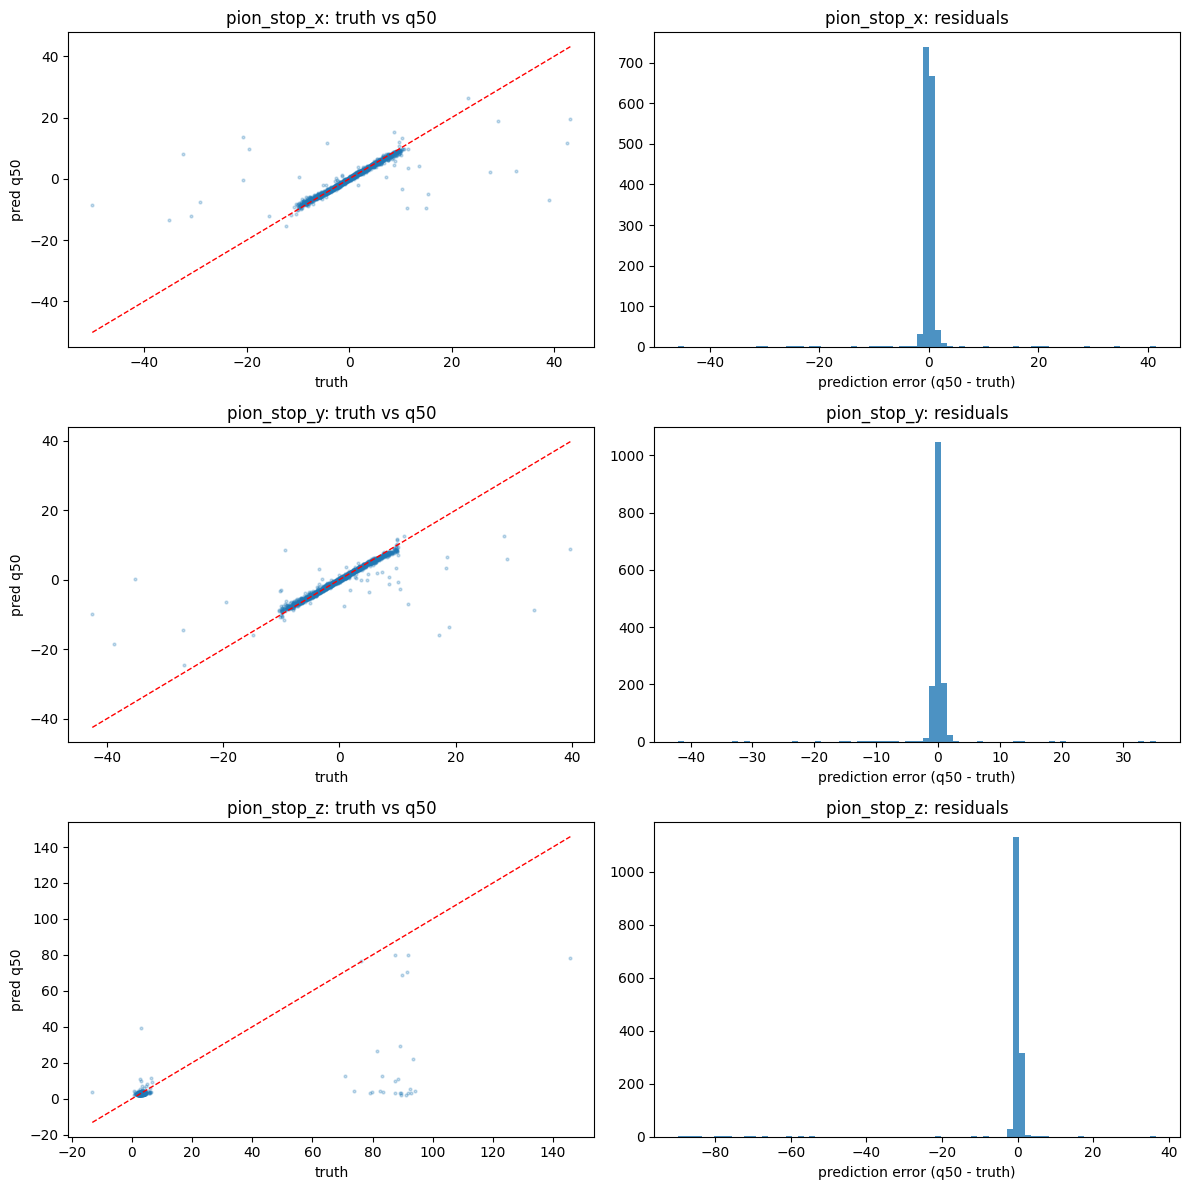

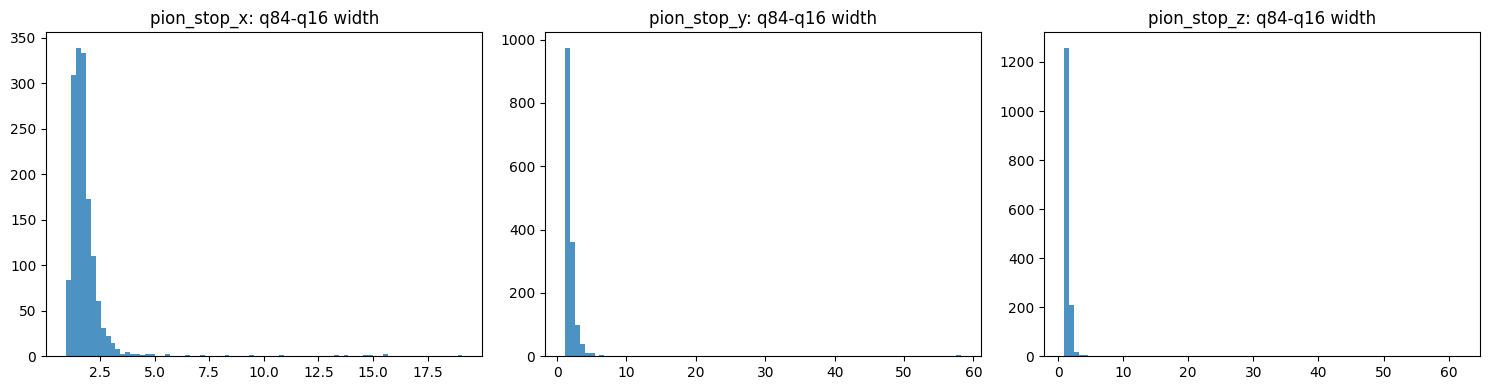

In [5]:
n = len(TARGET_COLS)
fig, axes = plt.subplots(n, 2, figsize=(12, 4*n))
if n == 1:
    axes = np.array([axes])
for i, (tcol, pcol) in enumerate(zip(TARGET_COLS, PRED_BASE_COLS)):
    y = df[tcol].to_numpy()
    pred = df[f'{pcol}_q50'].to_numpy()
    lo = df[f'{pcol}_q16'].to_numpy()
    hi = df[f'{pcol}_q84'].to_numpy()
    ax0 = axes[i, 0]
    ax0.scatter(y, pred, s=4, alpha=0.25)
    vmin = float(min(np.min(y), np.min(pred)))
    vmax = float(max(np.max(y), np.max(pred)))
    ax0.plot([vmin, vmax], [vmin, vmax], 'r--', linewidth=1)
    ax0.set_xlabel('truth')
    ax0.set_ylabel('pred q50')
    ax0.set_title(f'{tcol}: truth vs q50')

    ax1 = axes[i, 1]
    err = pred - y
    ax1.hist(err, bins=80, alpha=0.8)
    ax1.set_xlabel('prediction error (q50 - truth)')
    ax1.set_title(f'{tcol}: residuals')

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, len(TARGET_COLS), figsize=(5*len(TARGET_COLS), 4))
if len(TARGET_COLS) == 1:
    axes = [axes]
for ax, tcol, pcol in zip(axes, TARGET_COLS, PRED_BASE_COLS):
    width = (df[f'{pcol}_q84'] - df[f'{pcol}_q16']).to_numpy()
    ax.hist(width, bins=80, alpha=0.8)
    ax.set_title(f'{tcol}: q84-q16 width')
plt.tight_layout()
plt.show()
